In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ignore harmless warnings
import warnings

warnings.filterwarnings("ignore")


In [2]:
train_transform = transforms.Compose(
    [
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)


In [3]:
test_transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)


In [4]:
root = "../Data/CATS_DOGS/"

train_data = datasets.ImageFolder(
    os.path.join(root, "train"), transform=train_transform
)
test_data = datasets.ImageFolder(os.path.join(root, "test"), transform=test_transform)

torch.manual_seed(42)

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10)

class_names = train_data.classes


In [5]:
class_names

['CAT', 'DOG']

In [6]:
len(train_data)

18743

In [7]:
len(test_data)

6251

In [8]:
for images, labels in train_loader:
    break

In [9]:
images.shape

torch.Size([10, 3, 224, 224])

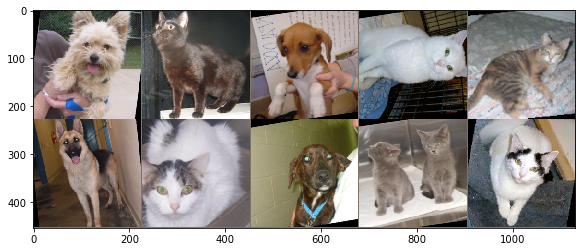

In [10]:
im = make_grid(images, nrow=5)

# Inverse the normalization
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
)

im_inv = inv_normalize(im)

plt.figure(figsize=(12, 4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))


In [11]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolutional_layer_1 = nn.Conv2d(
            3, 6, 3, 1
        )  # 3 color channels (inputs), 6 filters, kernel_size=3, stride=1
        self.convolutional_layer_2 = nn.Conv2d(6, 16, 3, 1)
        self.fully_connected_layer_1 = nn.Linear(54 * 54 * 16, 120)
        self.fully_connected_layer_2 = nn.Linear(120, 84)
        self.fully_connected_layer_3 = nn.Linear(84, 2)

    def forward(self, X):
        X = F.relu(self.convolutional_layer_1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.convolutional_layer_2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54 * 54 * 16)
        X = F.relu(self.fully_connected_layer_1(X))
        X = F.relu(self.fully_connected_layer_2(X))
        X = self.fully_connected_layer_3(X)

        return F.log_softmax(X, dim=1)


In [12]:
torch.manual_seed(101)
CNN_model = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNN_model.parameters(), lr=0.001)

In [13]:
CNN_model

ConvolutionalNetwork(
  (convolutional_layer_1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (convolutional_layer_2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fully_connected_layer_1): Linear(in_features=46656, out_features=120, bias=True)
  (fully_connected_layer_2): Linear(in_features=120, out_features=84, bias=True)
  (fully_connected_layer_3): Linear(in_features=84, out_features=2, bias=True)
)

In [14]:
# How many params do we have?
for p in CNN_model.parameters():
    print(p.numel())

162
6
864
16
5598720
120
10080
84
168
2


In [15]:
import time

start_time = time.time()

epochs = 3

# Limit number of batches (to save some time)
max_trn_batch = 800  # batch of 10 images --> 8000 images
max_tst_batch = 300  # batch of 10 images --> 3000 images

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for epoch in range(epochs):
    epoch += 1

    trn_corr = 0
    tst_corr = 0

    for batch, (X_train, y_train) in enumerate(train_loader):
        # Optional limit number of batches
        if batch == max_trn_batch:
            break

        batch += 1

        y_pred = CNN_model(X_train)
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 200 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Test set
    with torch.no_grad():
        for batch, (X_test, y_test) in enumerate(test_loader):
            # OPTIONAL 
            if batch == max_tst_batch:
                break

            y_val = CNN_model(X_test)

            predicted = torch.max(y_pred.data, 1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr += batch_corr

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)


total_time = time.time() - start_time
print(f"Total time: {total_time / 60} minutes")


Epoch 0, Loss: 0.7260900139808655
Epoch 0, Loss: 0.7165840864181519
Epoch 0, Loss: 0.6454009413719177
Epoch 0, Loss: 0.585983157157898
Epoch 1, Loss: 0.3046019375324249
Epoch 1, Loss: 0.5955299139022827
Epoch 1, Loss: 0.6143876910209656
Epoch 1, Loss: 0.4154497981071472
Epoch 2, Loss: 0.4807679057121277
Epoch 2, Loss: 0.4540594518184662
Epoch 2, Loss: 0.4581299424171448
Epoch 2, Loss: 0.42388907074928284
Total time: 6.6390292882919315 minutes


In [16]:
# Save the model!
torch.save(CNN_model.state_dict(), 'my3epochmodel.pt')

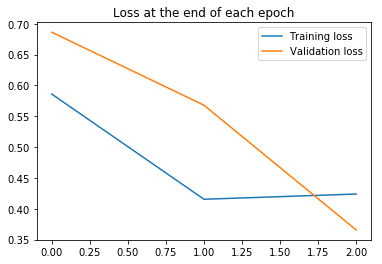

In [17]:
# Visualize
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Validation loss")
plt.title("Loss at the end of each epoch")
plt.legend();


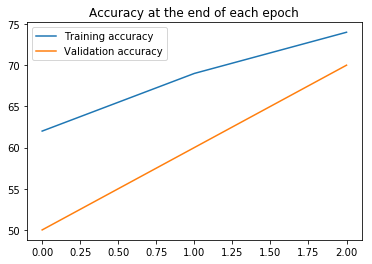

In [18]:
plt.plot([t / 80 for t in train_correct], label="Training accuracy")
plt.plot([t / 30 for t in test_correct], label="Validation accuracy")
plt.title("Accuracy at the end of each epoch")
plt.legend();


In [20]:
print(f"Accuracy: {100 * test_correct[-1].item()/3000}%")


Accuracy: 70.0%


In [21]:
AlexNetModel = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /Users/zhaluza/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100.0%


In [22]:
for param in AlexNetModel.parameters():
    param.requires_grad = False

In [23]:
AlexNetModel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [24]:
torch.manual_seed(42)

AlexNetModel.classifier = nn.Sequential(
    nn.Linear(9216, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 2),
    nn.LogSoftmax(dim=1),
)


In [25]:
AlexNetModel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_featur

In [26]:
for param in AlexNetModel.parameters():
    print(param.numel())

23232
64
307200
192
663552
384
884736
256
589824
256
9437184
1024
2048
2


In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetModel.classifier.parameters(), lr=0.001)


In [28]:
import time

start_time = time.time()

epochs = 1

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b += 1

        # Apply the model
        y_pred = AlexNetModel(X_train)
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b % 200 == 0:
            print(
                f"epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%"
            )

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = AlexNetModel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f"\nDuration: {time.time() - start_time:.0f} seconds")  # print the time elapsed


epoch:  0  batch:  200 [  2000/8000]  loss: 0.03795779  accuracy:  87.950%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.10626791  accuracy:  90.375%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.02011442  accuracy:  91.383%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.11830048  accuracy:  91.750%

Duration: 226 seconds


In [31]:
print(f"Accuracy: {test_correct[-1].item() / 3000 * 100}%")


Accuracy: 86.36666666666667%


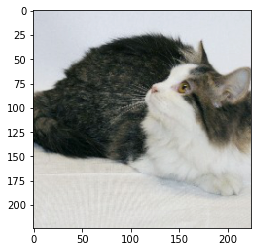

In [32]:
# Grab an image to run through our models
image_idx = 2019

im = inv_normalize(test_data[image_idx][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))


In [33]:
# Now let's run it through our original model

CNN_model.eval()  # Sets the model in evaluation mode

with torch.no_grad():
    new_pred = CNN_model(test_data[image_idx][0].view(1, 3, 224, 224)).argmax()

class_names[new_pred.item()] # What does our model predict?


'CAT'

In [34]:
# Now let's run it through our pretrained model

AlexNetModel.eval()  # Sets the model in evaluation mode

with torch.no_grad():
    new_pred = AlexNetModel(test_data[image_idx][0].view(1, 3, 224, 224)).argmax()

class_names[new_pred.item()] # What does our model predict?


'CAT'